In [187]:
#import keras essentials and stuff
import tensorflow as tf
from keras.layers import Dropout
from keras.layers import Dense
from keras import regularizers
from keras.models import Sequential

import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from pandas.core.common import SettingWithCopyWarning
import warnings
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

# Making a neural net
---
the neural net takes two input variables for now 
the genre(as one bit encoded) and a historical event (i.e second world war, vietnam war, etc).

genres are one hot encoded as wel as the historical event.
this is split per columns and each genre and historical event gets it's own column.

The output of the neural net is the amount of years after the given historical event, with number of rating and an average rating

# Preprocessing
---
preprocessing the data is necessary to make it suitable for the neural network

In [188]:
# import neccessary stuff 
#run this from the datascience-films folder
import pandas as pd 
import numpy as np
from pathlib import Path
# ignore some warnings, not pressing to fix these issues, more annoying to show these
from pandas.core.common import SettingWithCopyWarning
import warnings
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

RESOURCE_PATH = Path('../cleaned_data')

df = pd.read_csv(RESOURCE_PATH / 'cyclus_3_data.csv',sep=',')

In [189]:
# split genres per genre and create column per genre
unique_genres = pd.unique(df["genres"].str.split(",", expand=True).stack())
df = df.join(df.pop('genres').str.get_dummies(sep=',').astype(bool))
df = df.join(df.pop('historical_event').str.join('').str.get_dummies().astype(bool))

# fill non historical events with a year after event of 0
# and drop nan values for average rating and numVotes
df.years_after_event = df.years_after_event.fillna(0)
df = df[df['averageRating'].notna()]


In [190]:
#lastly pop our target we want
target = df[['years_after_event','numVotes','averageRating']]
target.averageRating =  target.averageRating.fillna(1)
target['numVotes'] = target['numVotes'].astype(np.int64)
target['averageRating'] = target['averageRating'].astype(np.int64)

In [191]:
# get numeric features and set as target
numeric_feature_names =  list(unique_genres)
numeric_feature_names.append('Vietnam War')
numeric_feature_names.append('Second World War')
numeric_features = df[numeric_feature_names]

In [192]:
# splitting the data
from sklearn.model_selection import train_test_split

# splits the training and test data set in 65% : 35%
# assign random_state to any value.This ensures consistency.
X_train, X_test, Y_train, Y_test = train_test_split(numeric_features, target, test_size = 0.30, random_state=60)

print(X_train.shape)
print(Y_train.shape)

print(X_test.shape)
print(Y_test.shape)


(726, 27)
(726, 3)
(312, 27)
(312, 3)


# Neural net
---
this part is for initializing the neural net

In [193]:
# convert to the features to a tensor

X_train = tf.convert_to_tensor(X_train, dtype=tf.int64)
Y_train = tf.convert_to_tensor(Y_train, dtype=tf.int64)
X_test = tf.convert_to_tensor(X_test, dtype=tf.int64)
Y_test = tf.convert_to_tensor(Y_test, dtype=tf.int64)

inputs = np.concatenate((X_train, X_test), axis=0)
targets = np.concatenate((Y_train, Y_test), axis=0)



In [194]:
class Neural_Net():

    def __init__(self):
        """
        Set up the neural net. 
        - input nodes: 
            - historical event label
            - genre 
            - number of expected reviews to get.
        - output node 
            - predicted release year
            - average predicted rating
        """

        # Define the K-fold Cross Validator
        self.kfold = KFold(n_splits=10, shuffle=True)
        self.fold_no = 1

        self.acc_per_fold = []
        self.loss_per_fold = []
        self.scores = []
        self.history_list = []


    def train(self, epochs: int):
        for train, test in self.kfold.split(inputs, targets):
            self.model = Sequential([
            Dense(50, input_shape=[27,], activation='relu', kernel_regularizer=regularizers.l2(0.05)),
            Dropout(0.5),
            Dense(300,  activation='relu', kernel_regularizer=regularizers.l2(0.01)),
            Dropout(0.5),
            Dense(400,  activation='relu', kernel_regularizer=regularizers.l2(0.01)),
            Dropout(0.5),
            Dense(3, activation='softplus')
        ])
            
            self.model.compile(
                optimizer= 'adam',
                loss='mean_squared_logarithmic_error'
                , metrics= ['accuracy']
                )

            self.history = self.model.fit(
                inputs[train],
                targets[train],
                epochs=epochs,
                batch_size=100,
                validation_split = 0.3,
                verbose=0
                )

            
            scores = self.model.evaluate(inputs[test], targets[test], verbose=0)
            print(f'Score for fold {self.fold_no}: {self.model.metrics_names[0]} of {scores[0]}; {self.model.metrics_names[1]} of {scores[1]*100}%')
            self.acc_per_fold.append(scores[1] * 100)
            self.loss_per_fold.append(scores[0])

            # Increase fold number
            self.history_list.append(self.history)
            self.fold_no = self.fold_no + 1
    
    def predict(self, input: tf.Tensor):
        predictions = self.model.predict(input)
        for prediction in predictions:
            print("predictions shape:", prediction.shape)
            print(f"prediction: {prediction}")

    def convert_to_input(self, list_of_inputs: list):
        tmp_df = pd.DataFrame(columns=numeric_feature_names)
        for index,sample in enumerate(list_of_inputs):
            tmp_df = tmp_df.append(pd.Series(dtype=bool), ignore_index=True)
            for col_index, _ in enumerate(tmp_df.columns):
                for genre in sample[0]:
                    tmp_df.loc[index, tmp_df.columns.values == genre] = True
                if col_index == 25:
                    for event in sample[1]:
                        tmp_df.loc[index, tmp_df.columns.values == event] = True
        tmp_df = tmp_df.fillna(False)
        return tf.convert_to_tensor(tmp_df, dtype=tf.int64)




    def save(self, path):
        """
        save the trained weights.
        """
        self.model.save_weights(path)
    
    def load(self, path: str):
        """
        load the weights of the model
        """
        self.model.load_weights(path)

    def plot_cost(self, min_fold_no, max_fold_no, min_epoch = 0 , max_epoch = 2000):
            for fold_no in range(min_fold_no, max_fold_no):
                history_dict = self.history_list[fold_no].history
                loss = history_dict['loss']
                val_loss = history_dict['val_loss']
                epochs = range(1, len(loss) + 1)

                plt.plot(epochs, loss, label=f'Training_loss {fold_no}')
                plt.plot(epochs,val_loss, label=f'Val_loss {fold_no}')
                plt.title(f'loss for cross validation')
                plt.xlabel('Epochs')
                plt.ylabel('Loss')
                plt.xlim(min_epoch, max_epoch)
            plt.legend()
            plt.show()

    def plot_acc(self, min_fold_no, max_fold_no, min_epoch = 0, max_epoch = 2000):
        for fold_no in range(min_fold_no, max_fold_no):
            history_dict = self.history_list[fold_no].history
            loss = history_dict['loss']
            acc = history_dict['accuracy']
            val_acc = history_dict['val_accuracy']
            epochs = range(1, len(loss) + 1)

            plt.plot(epochs, val_acc, label=f'Validation acc {fold_no}')
            plt.plot(epochs, acc, label=f'acc {fold_no}')
            plt.title('accuracy for cross validation')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.xlim(min_epoch, max_epoch)
        plt.legend()
        plt.show()

model = Neural_Net()

In [195]:
#train the model
model.train(50)

Score for fold 1: loss of 3.213176727294922; accuracy of 90.38461446762085%
Score for fold 2: loss of 3.042463541030884; accuracy of 92.30769276618958%
Score for fold 3: loss of 3.0353493690490723; accuracy of 92.30769276618958%
Score for fold 4: loss of 2.5711119174957275; accuracy of 97.11538553237915%
Score for fold 5: loss of 2.598156213760376; accuracy of 94.2307710647583%
Score for fold 6: loss of 3.0813827514648438; accuracy of 100.0%
Score for fold 7: loss of 2.2315866947174072; accuracy of 94.2307710647583%
Score for fold 8: loss of 2.762026071548462; accuracy of 96.15384340286255%
Score for fold 9: loss of 2.8613789081573486; accuracy of 93.20388436317444%
Score for fold 10: loss of 2.6774394512176514; accuracy of 95.14563083648682%


In [127]:
#save the model:
model.save('checkpoints/cross_validated_save_RMSLE_Adam')

In [128]:
#load the model
model.load('checkpoints/cross_validated_save_RMSLE_Adam')

In [173]:
#predict using the model
use_samples = [
    [['War',"Documentary"],["Vietnam War"]],
    [["War"], ["Second World War"]],
    [["Documentary"],["Vietnam War"]],
    [["Action"],[]],
    [["Documentary","War"],["Second World War"]],
    [["Short"],["Vietnam War"]],
    [["Romance"],[""]]
    ]
new_data = model.convert_to_input(use_samples)
model.predict(new_data)

predictions shape: (3,)
prediction: [ 1.0528243 72.40809    4.490082 ]
predictions shape: (3,)
prediction: [ 14.912057 133.46626    4.71887 ]
predictions shape: (3,)
prediction: [6.1880252e-03 4.0473232e+01 4.4732552e+00]
predictions shape: (3,)
prediction: [5.5947136e-03 7.0244057e+01 5.8384643e+00]
predictions shape: (3,)
prediction: [ 13.556541 131.06734    4.790876]
predictions shape: (3,)
prediction: [8.2304711e-03 1.7849470e+01 3.4064047e+00]
predictions shape: (3,)
prediction: [3.2210525e-02 5.2938541e+01 4.5147824e+00]


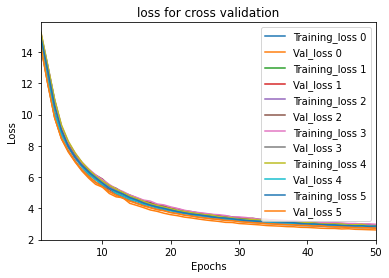

In [207]:
model.plot_cost(0,6,1,50)

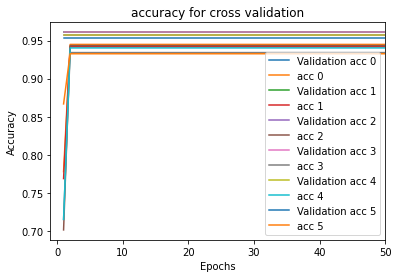

In [208]:
model.plot_acc(0,6,-1,50)